# Dissolved Iron Datasets for Validation
## GEOTRACES & ML dFe Data

Note:
 - Requires storage gdata/e14+gdata/ua8

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import numpy as np
import netCDF4 as nc
import xarray as xr
import pandas as pd
import cmocean.cm as cmocean
import glob
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.colors as col
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter

# import logging
# logging.captureWarnings(True)
# logging.getLogger('py.warnings').setLevel(logging.ERROR)

# from dask.distributed import Client

# change to your own directory on /g/data/:
figdir = Path('/g/data/e14/as3189/stellema/ACCESS-WOMBAT_01deg_BGC_validation/figs/')

# Datasets

## GEOTRACES Data

<details>
    <summary>Data variable details:</summary>
    
    metavar1	Cruise
    metavar2	Station
    metavar3	Type
    longitude	Longitude	degrees_east
    latitude	Latitude	degrees_north
    metavar4	Bot. Depth	m	Bottom depth
    metavar5	Operator's Cruise Name
    metavar6	Ship Name
    metavar7	Period
    metavar8	Chief Scientist
    metavar9	GEOTRACES Scientist
    metavar10	Cruise Aliases
    metavar11	Cruise Information Link
    metavar12	BODC Cruise Number
    date_time	Decimal Gregorian Days of the station	days since 2006-01-01 00:00:00 UTC	Relative Gregorian Days with decimal part
    var1	CTDPRS_T_VALUE_SENSOR	dbar	Pressure from CTD sensor
    var2	DEPTH	m	Depth below sea surface calculated from pressure
    var3	Rosette Bottle Number		Bottle number on the rosette
    var4	GEOTRACES Sample ID		GEOTRACES sample id
    var5	Bottle Flag		Quality flag for the entire bottle
    var6	Cast Identifier		Cast identifier as string
    var7	Sampling Device		Sampling device descriptor
    var8	BODC Bottle Number		Unique BODC bottle number
    var9	BODC Event Number		Unique BODC event number
    var88	Fe_D_CONC_BOTTLE	nmol/kg	Concentration of dissolved Fe
    var89	Fe_II_D_CONC_BOTTLE	nmol/kg	Concentration of dissolved Fe(II)
    var90	Fe_S_CONC_BOTTLE	nmol/kg	Concentration of operationally defined soluble Fe
</details>

In [2]:
def Fe_obs_GEOTRACES(var='var88', lats=[-10, 10], lons=[130, 285]):
    """Open geotraces data, subset location and convert to multi-dim dataset."""
    # @todo: drop bad data np.unique(ds.var5)
    # @todo: bin model depths?
    file = '/g/data/ua8/GEOTRACES/idp2021/GEOTRACES_IDP2021_v1/seawater/netcdf/GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1.nc'
    ds = xr.open_dataset(file)

    ds = ds.rename({'date_time': 'time', 'var2': 'depth'})
    ds['time'] = ds.time.astype(dtype='datetime64[D]')  # Remove H,M,S values from time.

    # Drop extra data variables.
    keep_vars = ['time', 'depth', 'latitude', 'longitude', var]
    ds = ds.drop([v for v in ds.data_vars if v not in keep_vars])
    
    # Subset lat/lons.
    ds = ds.where((ds.latitude >= lats[0]) & (ds.latitude <= lats[1]), drop=True)
    ds = ds.where((ds.longitude >= lons[0]) & (ds.longitude <= lons[1]), drop=True)
    
    # Drop coords where var is all NaN.
    ds = ds.dropna('N_SAMPLES', how='all')
    ds = ds.sel(N_SAMPLES=ds[var].dropna('N_SAMPLES', 'all').N_SAMPLES)
    
    # Convert to multi-dim array.
    ds = ds.stack({'index': ('N_STATIONS', 'N_SAMPLES')})
    ds = ds.drop_vars(['N_SAMPLES', 'N_STATIONS'])
    index = pd.MultiIndex.from_arrays([ds.time.values, ds.depth.values, 
                                       ds.latitude.values, ds.longitude.values], 
                                      names=['t', 'z', 'y', 'x'],)
    ds = ds.assign_coords({'index': index})
    ds = ds.dropna('index', how='all')
    ds = ds.unstack('index')
    ds = ds.drop(['time', 'depth', 'latitude', 'longitude'])

    # Add data var attrs.
    for v, n, u in zip(['y', 'x', 'z'], ['Latitude', 'Longitude', 'Depth'], ['°', '°', 'm']):
        # ds = ds.sortby(ds[v])  # very slow - only needed if new coordinates are out of order.
        ds = ds.dropna(v, 'all')
        ds[v].attrs['long_name'] = n
        ds[v].attrs['standard_name'] = n.lower()
        ds[v].attrs['units'] = u
    return ds

## Huang et al. (2022) ML compilation

In [3]:
def dFe_obs_ML():
    """Huang et al. (2022)
    dFe climatology based on compilation of dFe observations + environmental predictors
    from satellite observations and reanalysis products using machine-learning approaches
    (random forest).

    """
    file = '/g/data/e14/as3189/obs/Huang_et_al_2022_monthly_dFe_V2.nc'
    ds = xr.open_dataset(file)
    ds = ds.rename({'Longitude': 'x', 'Latitude': 'y', 'Depth': 'z', 'Month': 't'})
    ds.coords['x'] = xr.where(ds.x < 0, ds.x + 360, ds.x, keep_attrs=True)
    ds = ds.sortby(ds.x)
    for v, n, u in zip(['y', 'x', 'z'], ['Latitude', 'Longitude', 'Depth'], ['°', '°', 'm']):
        ds = ds.sortby(ds[v])
        ds[v].attrs['long_name'] = n
        ds[v].attrs['standard_name'] = n.lower()
        ds[v].attrs['units'] = u
    return ds.dFe_RF

### Function to create cartopy map for plots

In [4]:
def create_map_axis(figsize=(12, 5), extent=[120, 285, -10, 10]):
    """Create a figure and axis with cartopy."""
    projection = ccrs.PlateCarree(central_longitude=180)
    proj = ccrs.PlateCarree()
    proj._threshold /= 20.

    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=projection)

    # Set map extents: (lon_min, lon_max, lat_min, lat_max)
    ax.set_extent(extent, crs=proj)

    # Features.
    ax.add_feature(cfeature.LAND, color=cfeature.COLORS['land_alt1'])
    ax.add_feature(cfeature.COASTLINE)

    # Set ticks.
    xticks = np.arange(*extent[:2], 20)
    ax.set_xticks(xticks, crs=proj)
    ax.set_xticklabels(['{}°E'.format(i) for i in xticks])
    ax.set_yticks(ax.get_yticks(), crs=proj)
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    # # Minor ticks.
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    fig.subplots_adjust(bottom=0.2, top=0.8)
    ax.set_aspect('auto')
    return fig, ax, proj

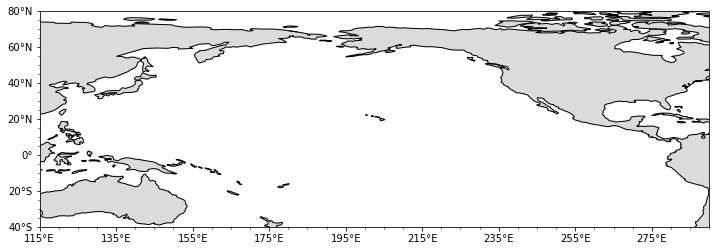

In [5]:
# for example
fig, ax, proj = create_map_axis(figsize=(12, 5), extent=[115, 290, -40, 70])

# GEOTRACES dFe data plots

In [6]:
# Open GEOTRACES dFe data subset (N.B. very slow/fails for large area subsets).
var = 'var88'
lats = [-9, 9]
lons = [140, 285]
ds = Fe_obs_GEOTRACES(var, lats, lons)
ds = ds[var]

In [ ]:
# dx = ds.sel(x=slice(147.7,  155), y=slice(-9.25, -3))
# dx = dx.where(~np.isnan(dx), drop=True)
# dx.mean('t').plot(col='z', col_wrap=5)

# Plot: all x-y locations.

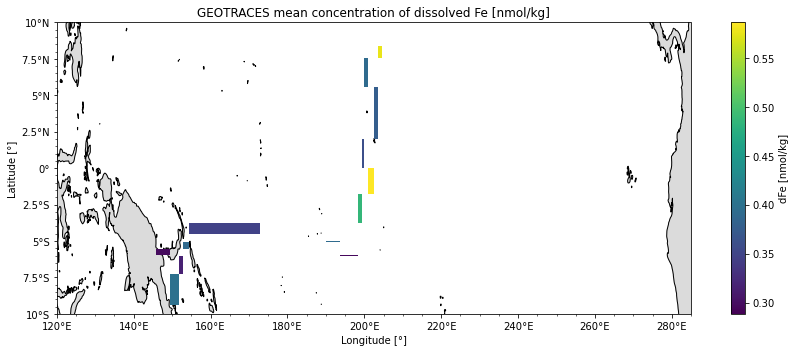

In [7]:
# Plot: all x-y locations.
fig, ax, proj = create_map_axis()
cs = ds.mean(['t', 'z'], skipna=True).plot(ax=ax, zorder=5, transform=proj)
ax.set_title('GEOTRACES mean concentration of dissolved Fe [nmol/kg]')
cbar = cs.colorbar
cbar.set_label('dFe [nmol/kg]')
plt.tight_layout()
plt.savefig(figdir / 'GEOTRACES_dFe_map.png')
plt.show()

# Plot: Vitiaz Strait & Solomon Strait.

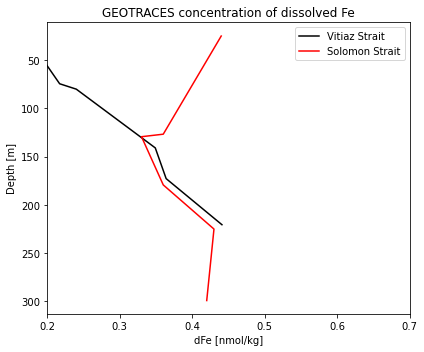

In [8]:
# Plot: Vitiaz Strait & Solomon Strait.
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
# Plot Vitiaz Strait
dx = ds.sel(y=-5.9, x=147.7, method='nearest')
for v in ['z', 't']:
    dx = dx.dropna(v, 'all')
ax.plot(dx.squeeze(), dx.z, color='k', label='Vitiaz Strait')
# Plot Solomon Strait
dx = ds.sel(y=-5.139, x=153.3, method='nearest')
for v in ['z', 't']:
    dx = dx.dropna(v, 'all')
ax.plot(dx.squeeze(), dx.z, color='r', label='Solomon Strait')

ax.set_title('GEOTRACES concentration of dissolved Fe')
ax.set_xlabel('dFe [nmol/kg]')
ax.set_ylabel('Depth [m]')
ax.invert_yaxis()
ax.set_xlim(0.2, 0.7)
ax.legend()
plt.tight_layout()
plt.savefig(figdir / 'GEOTRACES_dFe_straits.png')
plt.show()

# Huang et al. (2022) dFe data plots

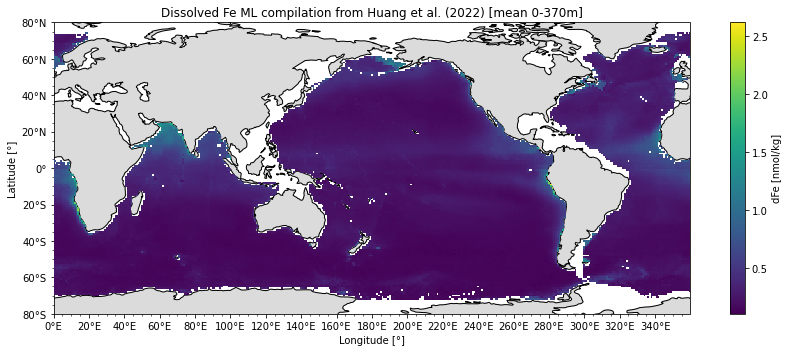

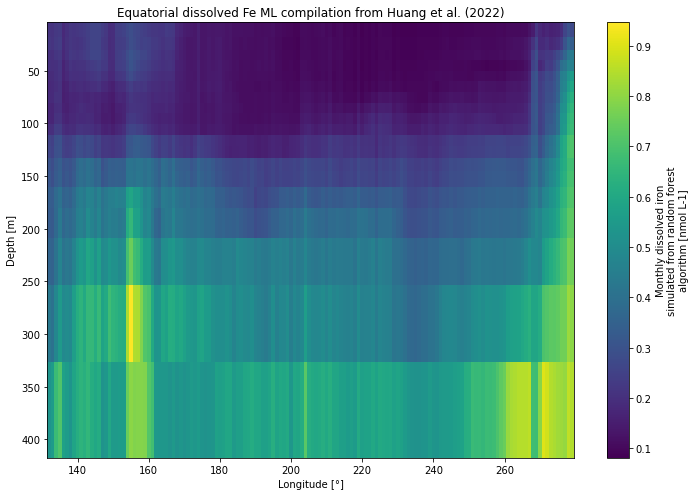

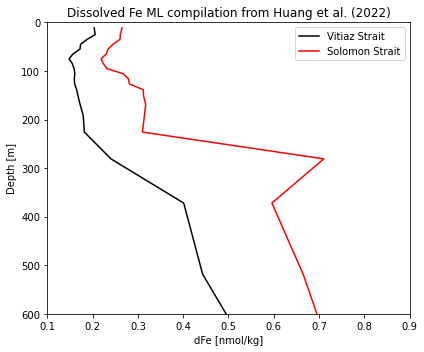

In [9]:
dx = dFe_obs_ML()
dx = dx.isel(t=-1)  # Annual.
# dx = dx.sel(y=slice(-30, 30), x=slice(120, 290), z=slice(0, 2000))

# Plot: all x-y locations.
dxx = dx.sel(z=slice(0, 400)).mean('z')
fig, ax, proj = create_map_axis(extent=[0, 360, -80, 80])
cs = dxx.plot(ax=ax, zorder=5, transform=proj)
ax.set_title('Dissolved Fe ML compilation from Huang et al. (2022) [mean 0-370m]')
cbar = cs.colorbar
cbar.set_label('dFe [nmol/kg]')
plt.tight_layout()
plt.savefig(figdir / 'dFe_obs_ML_map.png')
plt.show()

# Plot: equatorial depth profile.
fig, ax = plt.subplots(figsize=(10, 7))
dxx = dx.sel(y=0, x=slice(132, 279), z=slice(0, 400))
cs = dxx.plot(yincrease=False)
ax.set_title('Equatorial dissolved Fe ML compilation from Huang et al. (2022)')
plt.tight_layout()
plt.savefig(figdir / 'dFe_obs_ML_eq.png')
plt.show()

# Plot: straits depth profile.
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

dxx = dx.sel(y=-7, x=149, method='nearest')  # VS
ax.plot(dxx.squeeze(), dxx.z, color='k', label='Vitiaz Strait')
dxx = dx.sel(y=-5, x=155, method='nearest')  # SS
ax.plot(dxx.squeeze(), dxx.z, color='r', label='Solomon Strait')
ax.set_title('Dissolved Fe ML compilation from Huang et al. (2022)')
ax.set_xlabel('dFe [nmol/kg]')
ax.set_ylabel('Depth [m]')
ax.set_ylim(600, 0)
ax.set_xlim(0.1, 0.9)
ax.legend()
plt.tight_layout()
plt.savefig(figdir / 'dFe_obs_ML_straits.png')
plt.show()

ACCESS

In [12]:
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [13]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41275,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:43167,Total threads: 4
Dashboard: /proxy/36873/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:39721,


In [16]:
master_session = cc.database.create_session()

control = '01deg_jra55v140_iaf_cycle4'

start_time='2010-01-01'
# If you're having trouble with the amount of data, test your script with a shorter time period:
#end_time='1993-12-31'
end_time='2012-12-31'

In [17]:
# This is really slow to do in 3D for the whole globe, so let's just pick a transect:
longitude = 0
# iron:
fe = cc.querying.getvar(control, 'fe', master_session, ncfile='oceanbgc-3d%monthly%', start_time=start_time, end_time=end_time)
fe = fe.sel(time=slice(start_time, end_time)).sel(xt_ocean=longitude, method='nearest')
# compute climatology:
fe = fe.groupby('time.month').mean('time')
fe = fe.load()

2022-12-09 15:49:38,576 - distributed.worker - WARNING - Compute Failed
Key:       open_dataset-7d1ff101-33b0-4f0d-a4d7-6ce238258e46
Function:  execute_task
args:      ((<function apply at 0x14b5ef537160>, <function open_dataset at 0x14b5d3e1aca0>, ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf_cycle4/output959/ocean/oceanbgc-3d-fe-1-monthly-mean-3-sigfig-ym_2010_11.nc'], (<class 'dict'>, [['engine', None], ['chunks', (<class 'dict'>, [['time', 1], ['st_ocean', 19], ['yt_ocean', 135], ['xt_ocean', 180]])]])))
kwargs:    {}
Exception: "FileNotFoundError(2, 'No such file or directory')"

2022-12-09 15:49:38,579 - distributed.worker - WARNING - Compute Failed
Key:       open_dataset-40c7e784-69e2-4fe8-a9e4-15af3cf98d4c
Function:  execute_task
args:      ((<function apply at 0x14de2da88160>, <function open_dataset at 0x14de1259e310>, ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf_cycle4/output961/ocean/oceanbgc-3d-fe-1-monthly-mean-3-sigfig-y

FileNotFoundError: [Errno 2] No such file or directory: b'/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf_cycle4/output959/ocean/oceanbgc-3d-fe-1-monthly-mean-3-sigfig-ym_2010_11.nc'